In [2]:
import json
import json
from llm import *
from tqdm import tqdm
import re

In [50]:
with open(r"tasks\task4_full_score.json", "r", encoding="utf-8") as f:
    dataset_task4 = json.load(f)

In [39]:
l = []

In [52]:

for i in dataset_task4['samples']:
    sample = i['GT_HISTORY']

    for u in sample:
        l.append(u['utterance'])

In [53]:
len(l)

230

In [54]:
s = 0

for i in l:
    words = i.split()
    word_count = len(words)
    s += word_count


In [55]:
s

4334

In [56]:
s/len(l)

18.843478260869563

# LLM-as-a-Judge

In [50]:
PROMT_CHECK_INNER_THOUGHT_CONTENTS = """
Bạn được cung cấp một cuộc hội thoại gồm 10 turn giữa các bạn đang thảo luận về môn toán.

9 turns đầu tiên được đưa vào hệ thống chatbot AI để đoán ra tên người nói và AI đó sẽ thực hiện trả lời ở turn thứ 10 (đây được gọi là turn được generate bởi AI)
Ngoài ra khi generate câu trả lời, thì AI đó sẽ suy nghĩ trước khi nói (suy khi có tin nhắn ở turn 9, thì AI sẽ suy nghĩ để thực hiện turn 10).

## Nhiệm vụ:
Bạn sẽ đánh giá điểm dựa trên nội dung nói của AI so với nội dung của turn thứ 10 thật, trên thang điểm 1.0 - 10.0
Các thức chấm điểm:
Về nội dung lời nói của AI:
- Nếu như hai turn giống nhau về nội dung hay ý định giống nhau thì sẽ được cộng điểm. Ngược lại nếu nội dung hay ý định khác nhau thì trừ điểm
- Nếu như hai turn có điểm tương đồng, nhưng turn gen ra bởi AI thiếu hoặc thừa quá nhiều thì cần trừ điểm.
- Nếu như hai turn là tương đồng, nhưng cách nói chuyện của AI không giống người, ví dụ quá dài so với thực tế thì trừ điểm.
- Nếu như các nói chuyện của AI đó không đồng nhất như phong cách trước đó của họ thì cũng trừ điểm.
- Sẽ là một điểm cộng nếu AI diễn đạt theo cách khác so với thực tế nhưng vẫn cùng một ý định.

Về suy nghĩ của AI:
- Chấm điểm thêm điểm CỘNG nếu suy nghĩ của AI hướng tới hành động giống như sẽ thực hiện ở turn 10 thật. Phù hợp với hội thoại sự phát triển suy nghĩ của riêng họ trong hội thoại.
- Chấm điểm thêm điểm TRỪ nếu suy nghĩ của AI không hướng tới hành động đúng, cho dù ở turn 10 gen AI đã thực hiện đúng hành động so với turn 10 thật.

## Lưu ý:
- Điểm số là số thập phân (ví dụ: 1.2, 3.7, 8.9, 9.9,...)
- Hãy cẩn thận để khi nào CỘNG hoặc TRỪ điểm.

## Ouput: Chỉ trả về 2 dòng như sau, và không viết gì thêm:
<Giải thích cách chấm điểm> (dòng 1 dùng dể giải thích, đây là một chuỗi string)
<score><1.0-10.0></score> (dòng 2 là một số float để chấm điểm dựa trên giải thích trên được để trong tag <score></score>)


Ví dụ 1:
Turn gen ra bởi AI còn thiếu....
<score>5.7</score>


Ví dụ 2:
So với turn 10 thật...
<score>2.5</score>

Ví dụ 3:
Có thể thấy ...
<score>9.3</score>


## Đây là hội thoại (turn 1-9):
---
{history}
---

## Đây là turn 10 thật:
---
{gt}
---

## Đây là turn 10 gen bởi AI:
---
{gen}
---

LƯU Ý QUAN TRỌNG: phải trả về 2 dòng như mô tả đầu ra ở trên, dòng 2 là điểm số dạng float
- Dòng 1 chỉ chứa giải thích (chỉ được giải thích trên một dòng)
- Dòng 2 chỉ chứa duy nhât 1 số float mà không được chưa thêm bất kỳ ký tự nào, để trong tag <score></score>
"""

In [49]:
# Withou Thoughts
PROMT_CHECK_INNER_THOUGHT_CONTENTS_system1 = """
Bạn được cung cấp một cuộc hội thoại gồm 10 turn giữa các bạn đang thảo luận về môn toán.

9 turns đầu tiên được đưa vào hệ thống chatbot AI để đoán ra tên người nói và AI đó sẽ thực hiện trả lời ở turn thứ 10 (đây được gọi là turn được generate bởi AI)

## Nhiệm vụ:
Bạn sẽ đánh giá điểm dựa trên nội dung nói của AI so với nội dung của turn thứ 10 thật, trên thang điểm 1.0 - 10.0
Các thức chấm điểm:
(1) Chấm điểm dựa trên nội dung:
- Nếu như hai turn giống nhau về nội dung hay ý định giống nhau thì sẽ được cộng điểm. Ngược lại nếu nội dung hay ý định khác nhau thì trừ điểm
- Nếu như hai turn có điểm tương đồng, nhưng turn gen ra bởi AI thiếu hoặc thừa quá nhiều thì cần trừ điểm.
- Nếu như hai turn là tương đồng, nhưng cách nói chuyện của AI không giống người, ví dụ quá dài so với thực tế thì trừ điểm.
- Nếu như các nói chuyện của AI đó không đồng nhất như phong cách trước đó của họ thì cũng trừ điểm.
- Sẽ là một điểm cộng nếu AI diễn đạt theo cách khác so với thực tế nhưng vẫn cùng một ý định.

(2) Chấm điểm dựa trên AI đó nói có thích hợp:
- Nếu so với tên của người ở tên 10 thật, nếu tên của AI nói mà khác thì sẽ là điểm trừ lớn.
- Nếu khác tên người nói, nhưng nội dung vẫn tương tự thì vấn được tính điểm ở mức trung bình.

## Lưu ý:
- Điểm số là số thập phân (ví dụ: 1.2, 3.7, 8.9, 9.9,...)
- Hãy cẩn thận để khi nào CỘNG hoặc TRỪ điểm.

## Ouput: Chỉ trả về 2 dòng như sau, và không viết gì thêm:
<Giải thích cách chấm điểm> (dòng 1 dùng dể giải thích, đây là một chuỗi string)
<score><1.0-10.0></score> (dòng 2 là một số float để chấm điểm dựa trên giải thích trên được để trong tag <score></score>)


Ví dụ 1:
Turn gen ra bởi AI còn thiếu....
<score>5.7</score>


Ví dụ 2:
So với turn 10 thật...
<score>2.5</score>

Ví dụ 3:
Có thể thấy ...
<score>9.3</score>


## Đây là hội thoại (turn 1-9):
---
{history}
---

## Đây là turn 10 thật:
---
{gt}
---

## Đây là turn 10 gen bởi AI:
---
{gen}
---

LƯU Ý QUAN TRỌNG: phải trả về 2 dòng như mô tả đầu ra ở trên, dòng 2 là điểm số dạng float
- Dòng 1 chỉ chứa giải thích (chỉ được giải thích trên một dòng)
- Dòng 2 chỉ chứa duy nhât 1 số float mà không được chưa thêm bất kỳ ký tự nào, để trong tag <score></score>
"""

## Helper Function

In [10]:
def parse_json(resp):
    return json.loads(resp.strip('```json').strip('\n```'))

In [11]:
def format_gen(sample):
    formatted = ""

    next_ = sample[9]['name']
    utt_ = sample[9]['utterance']
    thoughts = sample[8]['thoughts']
    THO = next(item for item in thoughts if item['agent_name'] == next_)

    formatted += f"Tên: {next_}\nSuy nghĩ của AI: {THO['inner_thought']}\nLời nói gen ra ở turn 10: \"{utt_}\""
    return formatted

In [12]:
def format_gen_system1(sample):
    formatted = ""

    next_ = sample[9]['name']
    utt_ = sample[9]['utterance']


    formatted += f"Tên: {next_}\nLời nói gen ra ở turn 10: \"{utt_}\""
    return formatted

In [13]:
def formate_GT(sample):
    formatted = ""
    for u in sample[:-1]:
        formatted += f"{u['turn']}. {u['name']} : \"{u['message']}\"\n"

    return (sample[-1]['name'], sample[-1]['message']), formatted

In [51]:
def extract_score(text):
    match = re.search(r"<score>([\d.]+)</score>", text)
    if match:
        return float(match.group(1))
    return None

input_text = "Có thể thấy ...\n<score>9.3</score>"
score = extract_score(input_text)
print(score)

9.3


In [33]:
# LLM

gemini = LLM(provider="Google", model="gemini-pro", temperature = 0)
def llm_gemini(prompt):
    return gemini.generate(prompt)


gpt4o = LLM(provider="OpenAI", model="gpt-4o", temperature = 0)
def llm_gpt4o(prompt):
    return gpt4o.generate(prompt)


o4mini = LLM(provider="OpenAI", model="o4mini", temperature = 0.3)
def llm_o4mini(prompt):
    return o4mini.generate(prompt)




In [67]:
def score(prompt):
    # gpt_4o
    s = {"gpt4o" : None,
         "o4mini" : None,
         "geminipro" : None,
         "avg" : None}

    gpt_4o = llm_gpt4o(prompt)
    gpt_4o_s = extract_score(gpt_4o)
    s['gpt4o'] = gpt_4o_s

    o4mini = llm_o4mini(prompt)
    o4mini_s = extract_score(o4mini)
    s['o4mini'] = o4mini_s

    geminipro = llm_gemini(prompt)
    geminipro_s = extract_score(geminipro)
    s['geminipro'] = geminipro_s

    avg = (s['gpt4o'] + s['o4mini'] + s['geminipro']) / 3

    s['avg'] = avg

    return s

In [ ]:
def score_radar(task):
    gemini = 0.0
    gpt = 0.0
    gemma = 0.0
    system1 = 0.0
    for i in task:
        gemini += i[1]['gemini']['avg']
        gpt += i[1]['gpt4omini']['avg']
        gemma += i[1]['gemma']['avg']
        system1 += i[1]['system1']['avg']

    return {"gemini2flash" : gemini/len(task),
            "gpt4omini" : gpt/len(task),
            "gemma" : gemma/len(task),
            "system1" : system1/len(task)}

# SCORING...

In [84]:
idx = 0
for sample in tqdm(dataset_task4['data']):
    idx += 1
    try:
        print(idx)
        print(sample['score'])
        continue

    except:
        gt, history = formate_GT(sample['history'])

        ## Gemini
        gemini_g = format_gen(sample['inner_thought']['history'])
        prompt_1 = PROMT_CHECK_INNER_THOUGHT_CONTENTS.format(history = history,
                                                            gt = gt,
                                                            gen = gemini_g)
        
        print("--- GEMINI ---")
        # print(prompt_1)
        # print()
        gemini_score = score(prompt= prompt_1)


        sample['score'] = {"gemini" : None,
                        "gpt4omini" : None,
                        "gemma" : None}
        
        sample['score']['gemini'] = gemini_score
        print({"num" : idx, "model" : "gemini", "score" : gemini_score})

        
        ## Gpt-4o-mini
        gpt4omini_g = format_gen(sample['inner_thought']['history_4omini'])
        prompt_2 = PROMT_CHECK_INNER_THOUGHT_CONTENTS.format(history = history,
                                                            gt = gt,
                                                            gen = gpt4omini_g)
        
        print("--- 4o MINI ---")
        # print(prompt_2)
        # print()
        gpt_score = score(prompt= prompt_2)
        sample['score']['gpt4omini'] = gpt_score
        print({"num" : idx, "model" : "gpt_4o_mini", "score" : gpt_score})


        ## Gemma
        gemma_g = format_gen(sample['inner_thought']['history_gemma'])
        prompt_3 = PROMT_CHECK_INNER_THOUGHT_CONTENTS.format(history = history,
                                                            gt = gt,
                                                            gen = gemma_g)
        
        print("--- GEMMA ---")
        # print(prompt_3)
        # print()

        gemma_score = score(prompt= prompt_3)
        sample['score']['gemma'] = gemma_score
        print({"num" : idx, "model" : "gemma", "score" : gemma_score})
    

  0%|          | 0/20 [00:00<?, ?it/s]

1
--- GEMINI ---
{'num': 1, 'model': 'gemini', 'score': {'gpt4o': 2.0, 'o4mini': 2.0, 'geminipro': 2.0, 'avg': 2.0}}
--- 4o MINI ---
{'num': 1, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 1.5, 'o4mini': 1.2, 'geminipro': 1.2, 'avg': 1.3}}
--- GEMMA ---


  5%|▌         | 1/20 [00:14<04:30, 14.24s/it]

{'num': 1, 'model': 'gemma', 'score': {'gpt4o': 6.5, 'o4mini': 2.0, 'geminipro': 2.5, 'avg': 3.6666666666666665}}
2
--- GEMINI ---
{'num': 2, 'model': 'gemini', 'score': {'gpt4o': 3.5, 'o4mini': 2.0, 'geminipro': 2.0, 'avg': 2.5}}
--- 4o MINI ---
{'num': 2, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.0, 'o4mini': 2.0, 'geminipro': 2.0, 'avg': 2.3333333333333335}}
--- GEMMA ---


 10%|█         | 2/20 [00:28<04:16, 14.25s/it]

{'num': 2, 'model': 'gemma', 'score': {'gpt4o': 3.5, 'o4mini': 2.5, 'geminipro': 2.5, 'avg': 2.8333333333333335}}
3
--- GEMINI ---
{'num': 3, 'model': 'gemini', 'score': {'gpt4o': 7.5, 'o4mini': 8.2, 'geminipro': 7.8, 'avg': 7.833333333333333}}
--- 4o MINI ---
{'num': 3, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.0, 'o4mini': 2.0, 'geminipro': 2.5, 'avg': 2.5}}
--- GEMMA ---


 15%|█▌        | 3/20 [00:44<04:14, 15.00s/it]

{'num': 3, 'model': 'gemma', 'score': {'gpt4o': 7.0, 'o4mini': 7.8, 'geminipro': 7.5, 'avg': 7.433333333333334}}
4
--- GEMINI ---
{'num': 4, 'model': 'gemini', 'score': {'gpt4o': 8.5, 'o4mini': 8.5, 'geminipro': 8.2, 'avg': 8.4}}
--- 4o MINI ---
{'num': 4, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.0, 'o4mini': 6.5, 'geminipro': 6.5, 'avg': 5.333333333333333}}
--- GEMMA ---


 20%|██        | 4/20 [01:01<04:12, 15.78s/it]

{'num': 4, 'model': 'gemma', 'score': {'gpt4o': 6.8, 'o4mini': 7.8, 'geminipro': 8.2, 'avg': 7.599999999999999}}
5
--- GEMINI ---
{'num': 5, 'model': 'gemini', 'score': {'gpt4o': 7.5, 'o4mini': 8.2, 'geminipro': 8.2, 'avg': 7.966666666666666}}
--- 4o MINI ---
{'num': 5, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 8.5, 'o4mini': 9.2, 'geminipro': 9.2, 'avg': 8.966666666666667}}
--- GEMMA ---


 25%|██▌       | 5/20 [01:15<03:49, 15.31s/it]

{'num': 5, 'model': 'gemma', 'score': {'gpt4o': 7.5, 'o4mini': 7.8, 'geminipro': 7.8, 'avg': 7.7}}
6
--- GEMINI ---
{'num': 6, 'model': 'gemini', 'score': {'gpt4o': 8.5, 'o4mini': 9.5, 'geminipro': 8.5, 'avg': 8.833333333333334}}
--- 4o MINI ---
{'num': 6, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.0, 'o4mini': 6.5, 'geminipro': 6.5, 'avg': 5.333333333333333}}
--- GEMMA ---


 30%|███       | 6/20 [01:33<03:46, 16.20s/it]

{'num': 6, 'model': 'gemma', 'score': {'gpt4o': 8.5, 'o4mini': 8.5, 'geminipro': 8.5, 'avg': 8.5}}
7
--- GEMINI ---
{'num': 7, 'model': 'gemini', 'score': {'gpt4o': 3.0, 'o4mini': 2.0, 'geminipro': 2.0, 'avg': 2.3333333333333335}}
--- 4o MINI ---
{'num': 7, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 6.5, 'o4mini': 2.0, 'geminipro': 2.0, 'avg': 3.5}}
--- GEMMA ---


 35%|███▌      | 7/20 [01:51<03:38, 16.78s/it]

{'num': 7, 'model': 'gemma', 'score': {'gpt4o': 8.5, 'o4mini': 8.5, 'geminipro': 8.5, 'avg': 8.5}}
8
--- GEMINI ---
{'num': 8, 'model': 'gemini', 'score': {'gpt4o': 7.5, 'o4mini': 7.8, 'geminipro': 7.8, 'avg': 7.7}}
--- 4o MINI ---
{'num': 8, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 7.8, 'o4mini': 8.2, 'geminipro': 8.5, 'avg': 8.166666666666666}}
--- GEMMA ---


 40%|████      | 8/20 [02:06<03:14, 16.20s/it]

{'num': 8, 'model': 'gemma', 'score': {'gpt4o': 7.5, 'o4mini': 6.8, 'geminipro': 7.8, 'avg': 7.366666666666667}}
9
--- GEMINI ---
{'num': 9, 'model': 'gemini', 'score': {'gpt4o': 3.0, 'o4mini': 6.5, 'geminipro': 4.5, 'avg': 4.666666666666667}}
--- 4o MINI ---
{'num': 9, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 4.5, 'o4mini': 2.0, 'geminipro': 2.5, 'avg': 3.0}}
--- GEMMA ---


 45%|████▌     | 9/20 [02:29<03:20, 18.27s/it]

{'num': 9, 'model': 'gemma', 'score': {'gpt4o': 3.5, 'o4mini': 2.5, 'geminipro': 3.5, 'avg': 3.1666666666666665}}
10
--- GEMINI ---
{'num': 10, 'model': 'gemini', 'score': {'gpt4o': 9.0, 'o4mini': 9.2, 'geminipro': 9.2, 'avg': 9.133333333333333}}
--- 4o MINI ---
{'num': 10, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.5, 'o4mini': 1.2, 'geminipro': 2.0, 'avg': 2.2333333333333334}}
--- GEMMA ---


 50%|█████     | 10/20 [02:44<02:53, 17.31s/it]

{'num': 10, 'model': 'gemma', 'score': {'gpt4o': 8.0, 'o4mini': 7.8, 'geminipro': 7.8, 'avg': 7.866666666666667}}
11
--- GEMINI ---
{'num': 11, 'model': 'gemini', 'score': {'gpt4o': 3.5, 'o4mini': 7.5, 'geminipro': 7.5, 'avg': 6.166666666666667}}
--- 4o MINI ---
{'num': 11, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 6.0, 'o4mini': 3.5, 'geminipro': 2.5, 'avg': 4.0}}
--- GEMMA ---


 55%|█████▌    | 11/20 [03:01<02:34, 17.15s/it]

{'num': 11, 'model': 'gemma', 'score': {'gpt4o': 6.0, 'o4mini': 7.8, 'geminipro': 7.5, 'avg': 7.1000000000000005}}
12
--- GEMINI ---
{'num': 12, 'model': 'gemini', 'score': {'gpt4o': 6.5, 'o4mini': 8.2, 'geminipro': 7.8, 'avg': 7.5}}
--- 4o MINI ---
{'num': 12, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 7.5, 'o4mini': 7.5, 'geminipro': 7.5, 'avg': 7.5}}
--- GEMMA ---


 60%|██████    | 12/20 [03:17<02:15, 16.89s/it]

{'num': 12, 'model': 'gemma', 'score': {'gpt4o': 3.0, 'o4mini': 1.2, 'geminipro': 1.2, 'avg': 1.8}}
13
--- GEMINI ---
{'num': 13, 'model': 'gemini', 'score': {'gpt4o': 3.5, 'o4mini': 3.5, 'geminipro': 2.0, 'avg': 3.0}}
--- 4o MINI ---
{'num': 13, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.5, 'o4mini': 1.2, 'geminipro': 1.0, 'avg': 1.9000000000000001}}
--- GEMMA ---


 65%|██████▌   | 13/20 [03:33<01:54, 16.42s/it]

{'num': 13, 'model': 'gemma', 'score': {'gpt4o': 3.5, 'o4mini': 4.5, 'geminipro': 2.5, 'avg': 3.5}}
14
--- GEMINI ---
{'num': 14, 'model': 'gemini', 'score': {'gpt4o': 6.8, 'o4mini': 6.5, 'geminipro': 6.5, 'avg': 6.6000000000000005}}
--- 4o MINI ---
{'num': 14, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 6.8, 'o4mini': 7.5, 'geminipro': 7.5, 'avg': 7.266666666666667}}
--- GEMMA ---


 70%|███████   | 14/20 [03:52<01:44, 17.41s/it]

{'num': 14, 'model': 'gemma', 'score': {'gpt4o': 3.5, 'o4mini': 6.5, 'geminipro': 3.5, 'avg': 4.5}}
15
--- GEMINI ---
{'num': 15, 'model': 'gemini', 'score': {'gpt4o': 3.5, 'o4mini': 2.5, 'geminipro': 2.0, 'avg': 2.6666666666666665}}
--- 4o MINI ---
{'num': 15, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 6.5, 'o4mini': 3.5, 'geminipro': 6.5, 'avg': 5.5}}
--- GEMMA ---


 75%|███████▌  | 15/20 [04:08<01:24, 16.93s/it]

{'num': 15, 'model': 'gemma', 'score': {'gpt4o': 3.0, 'o4mini': 2.5, 'geminipro': 2.5, 'avg': 2.6666666666666665}}
16
--- GEMINI ---
{'num': 16, 'model': 'gemini', 'score': {'gpt4o': 4.5, 'o4mini': 2.0, 'geminipro': 2.5, 'avg': 3.0}}
--- 4o MINI ---
{'num': 16, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.0, 'o4mini': 2.5, 'geminipro': 1.2, 'avg': 2.2333333333333334}}
--- GEMMA ---


 80%|████████  | 16/20 [04:22<01:03, 15.98s/it]

{'num': 16, 'model': 'gemma', 'score': {'gpt4o': 2.0, 'o4mini': 1.2, 'geminipro': 1.2, 'avg': 1.4666666666666668}}
17
--- GEMINI ---
{'num': 17, 'model': 'gemini', 'score': {'gpt4o': 3.2, 'o4mini': 2.5, 'geminipro': 2.0, 'avg': 2.566666666666667}}
--- 4o MINI ---
{'num': 17, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.0, 'o4mini': 2.5, 'geminipro': 2.5, 'avg': 2.6666666666666665}}
--- GEMMA ---


 85%|████████▌ | 17/20 [04:50<00:58, 19.58s/it]

{'num': 17, 'model': 'gemma', 'score': {'gpt4o': 3.5, 'o4mini': 2.0, 'geminipro': 2.5, 'avg': 2.6666666666666665}}
18
--- GEMINI ---
{'num': 18, 'model': 'gemini', 'score': {'gpt4o': 2.0, 'o4mini': 1.2, 'geminipro': 1.2, 'avg': 1.4666666666666668}}
--- 4o MINI ---
{'num': 18, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.5, 'o4mini': 2.0, 'geminipro': 2.0, 'avg': 2.5}}
--- GEMMA ---


 90%|█████████ | 18/20 [05:05<00:36, 18.22s/it]

{'num': 18, 'model': 'gemma', 'score': {'gpt4o': 3.0, 'o4mini': 2.5, 'geminipro': 2.5, 'avg': 2.6666666666666665}}
19
--- GEMINI ---
{'num': 19, 'model': 'gemini', 'score': {'gpt4o': 6.8, 'o4mini': 8.2, 'geminipro': 9.2, 'avg': 8.066666666666666}}
--- 4o MINI ---
{'num': 19, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.0, 'o4mini': 2.0, 'geminipro': 1.5, 'avg': 2.1666666666666665}}
--- GEMMA ---


 95%|█████████▌| 19/20 [05:27<00:19, 19.45s/it]

{'num': 19, 'model': 'gemma', 'score': {'gpt4o': 2.0, 'o4mini': 1.2, 'geminipro': 1.2, 'avg': 1.4666666666666668}}
20
--- GEMINI ---
{'num': 20, 'model': 'gemini', 'score': {'gpt4o': 2.0, 'o4mini': 1.2, 'geminipro': 1.2, 'avg': 1.4666666666666668}}
--- 4o MINI ---
{'num': 20, 'model': 'gpt_4o_mini', 'score': {'gpt4o': 3.0, 'o4mini': 1.0, 'geminipro': 1.2, 'avg': 1.7333333333333334}}
--- GEMMA ---


100%|██████████| 20/20 [05:43<00:00, 17.19s/it]

{'num': 20, 'model': 'gemma', 'score': {'gpt4o': 3.0, 'o4mini': 2.0, 'geminipro': 1.2, 'avg': 2.066666666666667}}


In [91]:
with open("task4_score_v3.json", "w", encoding="utf-8") as f:
    json.dump(dataset_task4, f, ensure_ascii=False, indent=4)

In [92]:
# Score for system 1
idx = 0
for sample in tqdm(dataset_task4['data']):
    gt, history = formate_GT(sample['history'])

    gen = format_gen_system1(sample['speaker_prediction']['history'])
    prompt = PROMT_CHECK_INNER_THOUGHT_CONTENTS_system1.format(history = history,
                                                        gt = gt,
                                                        gen = gen)
    
    s = score(prompt= prompt)
    print(s)

    sample['score']['system1'] = s


  5%|▌         | 1/20 [00:05<01:46,  5.58s/it]

{'gpt4o': 6.0, 'o4mini': 6.5, 'geminipro': 6.5, 'avg': 6.333333333333333}


 10%|█         | 2/20 [00:10<01:31,  5.09s/it]

{'gpt4o': 8.0, 'o4mini': 8.2, 'geminipro': 8.2, 'avg': 8.133333333333333}


 15%|█▌        | 3/20 [00:15<01:28,  5.22s/it]

{'gpt4o': 6.0, 'o4mini': 7.5, 'geminipro': 7.8, 'avg': 7.1000000000000005}


 20%|██        | 4/20 [00:20<01:21,  5.07s/it]

{'gpt4o': 2.0, 'o4mini': 2.0, 'geminipro': 1.2, 'avg': 1.7333333333333334}


 25%|██▌       | 5/20 [00:24<01:10,  4.68s/it]

{'gpt4o': 9.8, 'o4mini': 8.5, 'geminipro': 8.5, 'avg': 8.933333333333334}


 30%|███       | 6/20 [00:29<01:06,  4.77s/it]

{'gpt4o': 4.0, 'o4mini': 4.5, 'geminipro': 4.5, 'avg': 4.333333333333333}


 35%|███▌      | 7/20 [00:35<01:08,  5.27s/it]

{'gpt4o': 2.0, 'o4mini': 1.2, 'geminipro': 1.2, 'avg': 1.4666666666666668}


 40%|████      | 8/20 [00:41<01:04,  5.36s/it]

{'gpt4o': 2.0, 'o4mini': 1.2, 'geminipro': 1.5, 'avg': 1.5666666666666667}


 45%|████▌     | 9/20 [00:45<00:56,  5.15s/it]

{'gpt4o': 2.0, 'o4mini': 1.2, 'geminipro': 1.2, 'avg': 1.4666666666666668}


 50%|█████     | 10/20 [00:50<00:49,  4.91s/it]

{'gpt4o': 3.0, 'o4mini': 4.5, 'geminipro': 4.5, 'avg': 4.0}


 55%|█████▌    | 11/20 [00:54<00:41,  4.64s/it]

{'gpt4o': 3.0, 'o4mini': 2.0, 'geminipro': 3.5, 'avg': 2.8333333333333335}


 60%|██████    | 12/20 [00:59<00:39,  4.88s/it]

{'gpt4o': 2.0, 'o4mini': 3.5, 'geminipro': 3.5, 'avg': 3.0}


 65%|██████▌   | 13/20 [01:03<00:32,  4.62s/it]

{'gpt4o': 1.5, 'o4mini': 3.5, 'geminipro': 3.5, 'avg': 2.8333333333333335}


 70%|███████   | 14/20 [01:08<00:27,  4.56s/it]

{'gpt4o': 3.5, 'o4mini': 3.5, 'geminipro': 3.5, 'avg': 3.5}


 75%|███████▌  | 15/20 [01:12<00:21,  4.37s/it]

{'gpt4o': 3.0, 'o4mini': 3.5, 'geminipro': 2.0, 'avg': 2.8333333333333335}


 80%|████████  | 16/20 [01:16<00:17,  4.41s/it]

{'gpt4o': 2.0, 'o4mini': 2.0, 'geminipro': 3.5, 'avg': 2.5}


 85%|████████▌ | 17/20 [01:21<00:13,  4.61s/it]

{'gpt4o': 3.0, 'o4mini': 4.5, 'geminipro': 4.5, 'avg': 4.0}


 90%|█████████ | 18/20 [01:26<00:09,  4.69s/it]

{'gpt4o': 2.0, 'o4mini': 1.0, 'geminipro': 1.0, 'avg': 1.3333333333333333}


 95%|█████████▌| 19/20 [01:30<00:04,  4.54s/it]

{'gpt4o': 3.0, 'o4mini': 2.0, 'geminipro': 2.0, 'avg': 2.3333333333333335}


100%|██████████| 20/20 [01:35<00:00,  4.76s/it]

{'gpt4o': 3.0, 'o4mini': 1.2, 'geminipro': 2.0, 'avg': 2.066666666666667}


In [93]:
with open("task4_full_score_v2.json", "w", encoding="utf-8") as f:
    json.dump(dataset_task4, f, ensure_ascii=False, indent=4)

In [95]:
task4_score = []
for sample in dataset_task4['data']:
    task4_score.append((sample['note'], sample['score']))

task_4 = {
    "name" : "Task 4",
    "score" : score_radar(task4_score)
}
task_4

{'name': 'Task 4',
 'score': {'gemini2flash': 5.193333333333333,
  'gpt4omini': 4.006666666666667,
  'gemma': 4.726666666666667,
  'system1': 3.6150000000000007}}

In [117]:
task1 = {'name': 'Task 1',
 'score': {'gemini2flash': 7.7,
  'gpt4omini': 5.757,
  'gemma': 6.54,
  'baseline': 7.02}}

In [118]:
task2 = {'name': 'Task 2',
 'score': {'gemini2flash': 6.5,
  'gpt4omini': 4.8,
  'gemma': 5.3,
  'baseline': 4.9}}

In [170]:
task3 = {'name': 'Task 3',
 'score': {'gemini2flash': 6.4,
  'gpt4omini': 5.35,
  'gemma': 5.7,
  'baseline': 6.0}}

In [120]:
task4 = {'name': 'Task 4',
 'score': {'gemini2flash': 5.193333333333333,
  'gpt4omini': 4.006666666666667,
  'gemma': 4.726666666666667,
  'system1': 3.6150000000000007}}

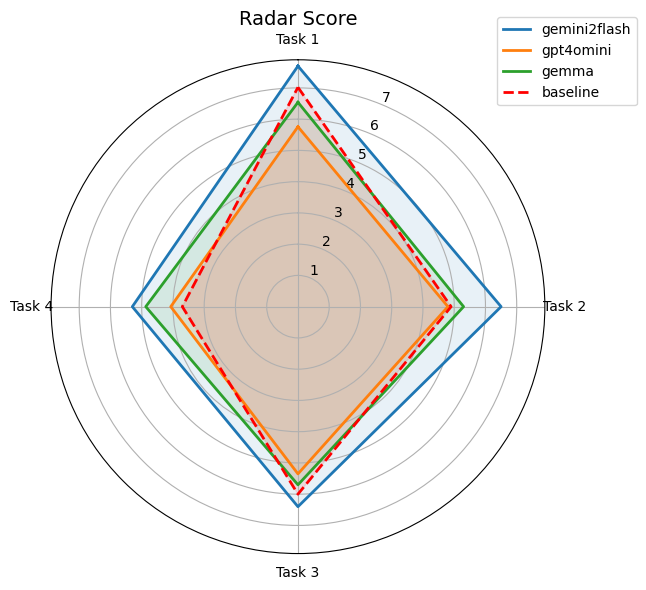

In [171]:
import matplotlib.pyplot as plt
import numpy as np

tasks = ['Task 1','Task 2', 'Task 3', 'Task 4']
models = ['gemini2flash', 'gpt4omini', 'gemma', 'baseline']

scores_by_model = {model: [] for model in models}
data = [task1, task2, task3, task4]

for task in data:
    for model in models:
        scores_by_model[model].append(task['score'][model])

# Radar plot
num_vars = len(tasks)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for model in models:
    values = scores_by_model[model]
    values += values[:1]  

    if model == 'baseline':
        ax.plot(angles, values, label=model, linewidth=2, linestyle='--', color='red')
        ax.fill(angles, values, alpha=0.1, color='red')
    else:
        ax.plot(angles, values, label=model, linewidth=2)
        ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), tasks)


plt.title("Radar Score", size=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_17364\1909599976.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


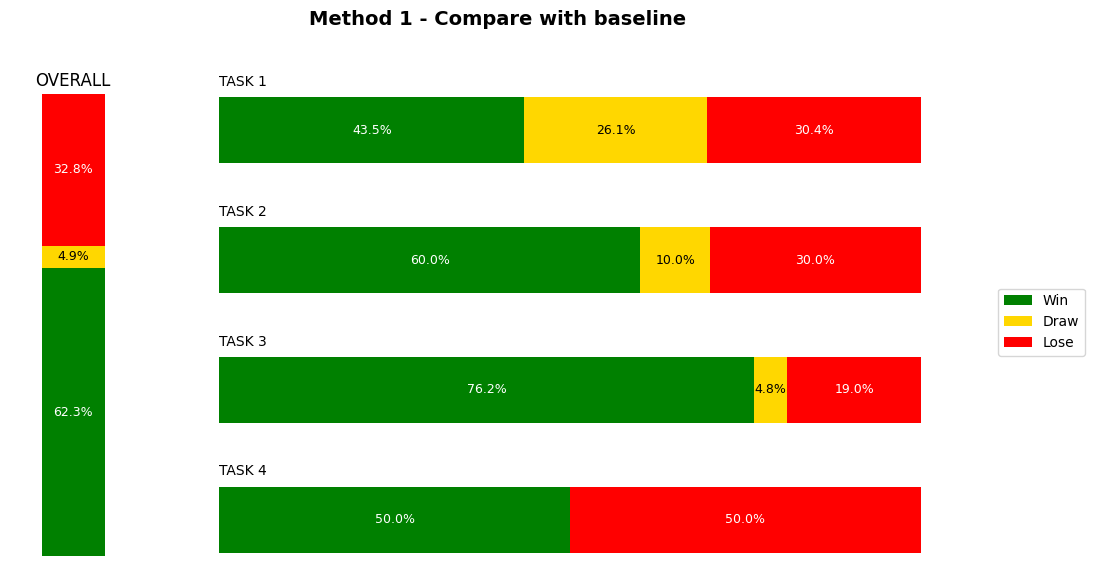

In [162]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Dữ liệu
tasks = ['TASK 1', 'TASK 2',
         'TASK 3', 'TASK 4']
categories = ['Win', 'Draw', 'Lose']
colors = ['green', 'gold', 'red']
task_data = [
    [43.5, 26.1, 30.4],
    [60.0, 10.0, 30.0],
    [76.2, 4.8, 19.0],
    [50.0, 0.0, 50.0]
]
overall_data = [62.3, 4.9, 32.8]


fig = plt.figure(figsize=(13, 6))
gs = fig.add_gridspec(4, 7, width_ratios=[1.8, 0.2, 3, 3, 3, 0.1, 0.3], wspace=0.3, hspace=0.8)


ax_overall = fig.add_subplot(gs[:, 0])
bottom = 0
for i, value in enumerate(overall_data):
    ax_overall.bar(0, value, bottom=bottom, color=colors[i], width=1.5)
    ax_overall.text(0, bottom + value / 2, f'{value:.1f}%', ha='center', va='center',
                    fontsize=9, color='white' if colors[i] != 'gold' else 'black')
    bottom += value
ax_overall.set_ylim(0, 100)
ax_overall.set_xlim(-1.5, 1.5)
ax_overall.set_xticks([])
ax_overall.set_yticks([])
ax_overall.set_title('OVERALL', fontsize=12)
for spine in ax_overall.spines.values():
    spine.set_visible(False)


for i in range(4):
    ax = fig.add_subplot(gs[i, 2:5])
    data = task_data[i]
    left = 0
    for j, value in enumerate(data):
        ax.barh(0, value, left=left, color=colors[j])
        if value > 0:
            ax.text(left + value / 2, 0, f'{value:.1f}%', va='center', ha='center',
                    fontsize=9, color='white' if colors[j] != 'gold' else 'black')
        left += value
    ax.set_xlim(0, 100)
    ax.set_title(tasks[i], loc='left', fontsize=10)
    ax.axis('off')


legend_elements = [Patch(facecolor=colors[i], label=categories[i]) for i in range(3)]
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.88, 0.5))

fig.suptitle("Method 1 - Compare with baseline", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
